In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [3]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train_data.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [5]:
test_data.isnull().sum()

Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [7]:
train_data = train_data.drop(["Descript", "Resolution"], axis = 1)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   DayOfWeek   878049 non-null  object 
 3   PdDistrict  878049 non-null  object 
 4   Address     878049 non-null  object 
 5   X           878049 non-null  float64
 6   Y           878049 non-null  float64
dtypes: float64(2), object(5)
memory usage: 46.9+ MB


In [9]:
def transformDataset(dataset):
    dataset['Dates'] = pd.to_datetime(dataset['Dates'])
    dataset['Date'] = dataset['Dates'].dt.date
    dataset['n_days'] = (dataset['Date'] - dataset['Date'].min()).apply(lambda x: x.days)

    dataset['Year'] = dataset['Dates'].dt.year
    dataset['DayOfWeek'] = dataset['Dates'].dt.dayofweek  # OVERWRITE
    dataset['WeekOfYear'] = dataset['Dates'].dt.weekofyear
    dataset['Month'] = dataset['Dates'].dt.month
    dataset['Hour'] = dataset['Dates'].dt.hour

    dataset['Block'] = dataset['Address'].str.contains('block', case=False)
    dataset['Block'] = dataset['Block'].map(lambda x: 1 if x == True else 0)

    dataset = dataset.drop('Dates', 1)
    dataset = dataset.drop('Date', 1)
    dataset = dataset.drop('Address', 1)

    dataset = pd.get_dummies(data=dataset, columns=['PdDistrict'], drop_first=True)
    return dataset

In [10]:
train_data = transformDataset(train_data)
test_data  = transformDataset(test_data)

In [11]:
train_data.head()

,Category,DayOfWeek,X,Y,n_days,Year,WeekOfYear,Month,Hour,Block,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,WARRANTS,2,-122.425892,37.774599,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
1,OTHER OFFENSES,2,-122.425892,37.774599,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
2,OTHER OFFENSES,2,-122.424363,37.800414,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
3,LARCENY/THEFT,2,-122.426995,37.800873,4510,2015,20,5,23,1,0,0,0,1,0,0,0,0,0
4,LARCENY/THEFT,2,-122.438738,37.771541,4510,2015,20,5,23,1,0,0,0,0,1,0,0,0,0


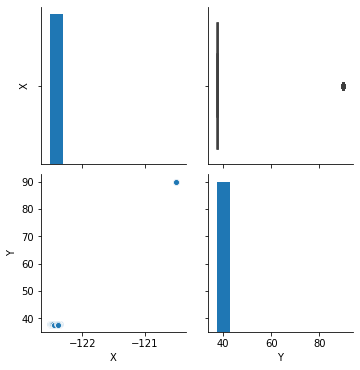

In [12]:
sns.pairplot(train_data[["X", "Y"]])
sns.boxplot(train_data[["Y"]])

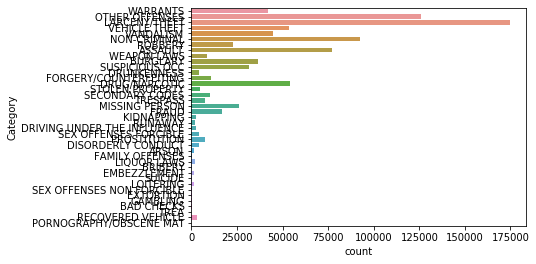

In [13]:
sns.countplot(y=train_data['Category'])

In [14]:
le = LabelEncoder()
train_data["Category"] = le.fit_transform(train_data["Category"])

In [15]:
train_data.head()

,Category,DayOfWeek,X,Y,n_days,Year,WeekOfYear,Month,Hour,Block,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,37,2,-122.425892,37.774599,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
1,21,2,-122.425892,37.774599,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
2,21,2,-122.424363,37.800414,4510,2015,20,5,23,0,0,0,0,1,0,0,0,0,0
3,16,2,-122.426995,37.800873,4510,2015,20,5,23,1,0,0,0,1,0,0,0,0,0
4,16,2,-122.438738,37.771541,4510,2015,20,5,23,1,0,0,0,0,1,0,0,0,0


In [16]:
X = train_data.drop("Category",axis=1).values
y = train_data["Category"].values

In [17]:
X.shape

(878049, 18)

In [18]:
y.shape

(878049,)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [20]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [21]:
rfc = RandomForestClassifier(n_estimators=40, min_samples_split=100 )
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
rfc_pred = rfc.predict(X_test)

In [23]:
classification_report(y_test,rfc_pred)

/opt/anaconda3/envs/PythonDataScienceExam/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       316\n           1       0.20      0.17      0.18     15514\n           2       0.00      0.00      0.00        75\n           3       0.00      0.00      0.00        59\n           4       0.24      0.03      0.06      7303\n           5       0.14      0.02      0.03       824\n           6       0.00      0.00      0.00       474\n           7       0.34      0.42      0.38     10904\n           8       0.00      0.00      0.00       823\n           9       0.00      0.00      0.00       240\n          10       0.00      0.00      0.00        42\n          11       0.00      0.00      0.00        93\n          12       0.07      0.00      0.00      2107\n          13       0.33      0.01      0.01      3279\n          14       0.00      0.00      0.00        28\n          15       0.00      0.00      0.00       462\n          16       0.30      0.76      0.43     34892\n       

In [24]:
keys = le.classes_
values = le.transform(le.classes_)

In [25]:
dictionary = dict(zip(keys, values))

In [26]:
test_data = test_data.drop('Id', 1)
y_pred_proba = rfc.predict_proba(test_data)

result = pd.DataFrame(y_pred_proba, columns=keys)

[Text(0.5, 1.0, 'prediction')]

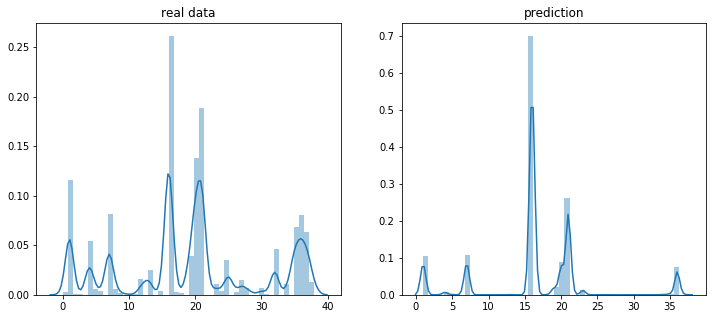

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_test, ax=ax1, bins=50)
ax1.set(title="real data")
sns.distplot(rfc_pred, ax=ax2, bins=50)
ax2.set(title="prediction")

In [28]:
score = cross_val_score(rfc, X_train, y_train, cv=k_fold,
                        n_jobs=1, scoring='accuracy')
score = score.mean()
print("Score = {0:.5f}".format(score))

Score = 0.29103


In [29]:
'''from sklearn.svm import SVC
clf = SVC(ker)
score = cross_val_score(clf, X_train, y_train, cv=k_fold,
                        n_jobs=1, scoring='accuracy')
score = score.mean()
print("Score = {0:.5f}".format(score))'''

'from sklearn.svm import SVC\nclf = SVC(ker)\nscore = cross_val_score(clf, X_train, y_train, cv=k_fold,\n                        n_jobs=1, scoring=\'accuracy\')\nscore = score.mean()\nprint("Score = {0:.5f}".format(score))'

In [30]:
#result.to_csv(path_or_buf="./rfc_predict_5.csv", index=True, index_label='Id')

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
eclf = GradientBoostingClassifier(n_estimators=1, learning_rate=0.1)
eclf.fit(X_train, y_train)
prediction = eclf.predict(X_test)
print(eclf.score(X_train, y_train))

0.19956608331826678


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

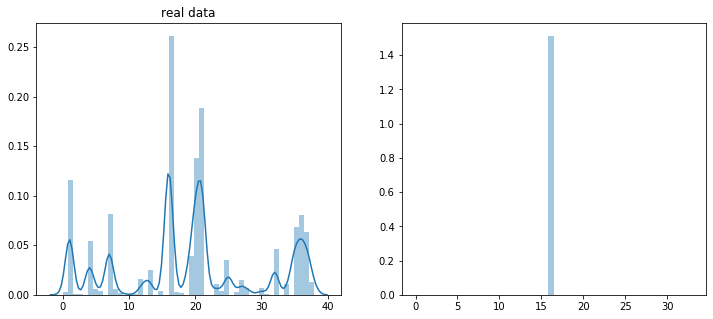

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_test, ax=ax1, bins=50)
ax1.set(title="real data")
sns.distplot(prediction, ax=ax2, bins=50)
ax2.set(title="prediction")